<h1><center>Data Mining Project</center></h1>
<h3><center>Music recommendation using emotion recognition</center></h3>
<h3>Réalisé par: </h3>
<ul>
    <li>Jawhar AFLI</li>
    <li>Helmi GHENIA</li>
</ul>


# 1- Project understanding

<p>L'idée de notre projet se présente comme un premier pas vers la personnalisation des suggestions musicales en fonction de l'humeur actuelle de l'utilisateur. Cette fonctionnalité est en fait l'objectif actuel de nombreuses plateformes telles que Youtube qui travaille actuellement sur un nouveau produit appelé Youtube music. </p></br>
Notre projet est divisé en deux parties :
<ol>
    <li>Reconnaissance des émotions présentes dans la chansons selon sa revue (NLP of reviews)</li>
    <li>Recommendation des chansons par reconnaissance des émotions faciales: Neutre, triste, fâché, heureux.</li>
</ol>


# A) Natural language processing

## A.2- Data understanding

<p>Afin d'assurer la reconnaissance des émotions présentes dans la chansons en se basant sur leurs revues, nous avons été amenés, dans ce projet à collecter les données nécessaires en passant par deux étapes: </p>
<ol>
    <li>le Web scrapping du site web du site web <a href="https://www.fesliyanstudios.com/">fesliyanstudios</a> afin d'extraire les informations sur les chnasons, leurs revues et leurs catégories d'émotion.</li>
    <li>L'ajout de data, présente dans Kaggle qui est de même nature que notre data mais d'une distribution diffèrentes, au training set afin d'améliorer les performances de notre modèle</li>
</ol>


### A.2.1- Web Scrapping


<p>Lors du scapping du site web <a href="https://www.fesliyanstudios.com/">fesliyanstudios</a>, nous avons fusionné des sentiments qui sont en relation avec les sentiments dont nous voulons obtenir. Du coup nous présentons ci-dessus la liste des sentiments utilisés pour chaque catégorie envisagée:</p>
<ul>
    <li><b>Sad = </b>[Suspenseful, Sad, Romantic]</li>
    <li><b>Happy = </b>[Peaceful And Relaxing,Funky, Funny, Happy, Upbeat]</li>
    <li><b>Angry  = </b>[Motivating And Inspiring, Epic, Mysterious, Dark]</li>
</ul>

   ## A.3- Data preparation

In [1]:
import numpy as np
import pandas as pd 
from PIL import Image
from tqdm import tqdm
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### A.3.1- Web Scrapping

In [3]:
import requests 
from bs4 import BeautifulSoup

<ul>
    <li><b>Input:</b> url</li>
    <li><b>Output:</b> parsed text </li>
</ul>

In [4]:
def parse_url(url):
    response = requests.get(url)
    content = response.content
    parsed_response = BeautifulSoup(content, "lxml")
    return parsed_response

<ul>
    <li><b>Input:</b> category url</li>
    <li><b>Output:</b> List of pages numbers in this category</li>
</ul>

In [5]:
def number_pages(url):
    soup=parse_url(url)
    pages=soup.findAll("a", {"class": "page-link"})
    str_pages=BeautifulSoup(str(pages), "lxml").get_text()
    page_nums=[elem.strip("(current)") for elem in str_pages[1:-1].split(",")[1:-1]]
    if len(page_nums)==0:
        page_nums.append("1")
    return page_nums

<ul>
    <li><b>Input:</b> the category link </li>
    <li><b>Output:</b> List of the links of the differents songs</li>
</ul>

In [6]:
def music_links(url):
    base_url=url+"?page="
    Links=[]
    a=0
    for i in number_pages(url):
        soup=parse_url(base_url+i)
        mydivs = soup.findAll("div", {"class": "row sfxMusicRow sfxDivRow"})
        for div in mydivs:
            link= "https://www.fesliyanstudios.com"+div.find_all('a')[0]['href']
            Links.append(link)
            span= div.find_all('span')[0]
            # print(a,link)
            a+=1
    return Links

<ul>
    <li><b>Input:</b> Song url, category</li>
    <li><b>Output:</b> List of the infos ([song,singer,youtube_link,description,category]) of the song </li>
</ul>

In [7]:
def song_infos(url,category):
    soup=parse_url(url)
    try:
        description_beautiful=soup.find("div", {"class": "col-md-6"}).find("p")
        description= BeautifulSoup(str(description_beautiful), "lxml").get_text()
    except:
        description_beautiful=soup.find("span", {"class": "trackTags"}).findAll("a")
        description=BeautifulSoup(str(description_beautiful), "lxml").get_text()[1:-1].strip()
    try:
        title_beautiful=soup.find("title")
        title= BeautifulSoup(str(title_beautiful), "lxml").get_text()
        song=title.split("by")[0]
        singer=title.split("by")[1].split("-")[0]
    except:
        song=""
        singer=""
    try:
        youtube_link=soup.find("iframe")["src"]
    except:
        youtube_link="https://www.youtube.com/results?search_query=angry+music+"+title.split("-")[0].strip().replace(" ", "+")
    return [song,singer,youtube_link,description,category]

<ul>
    <li><b>Input:</b> website main url</li>
    <li><b>Output:</b> List of urls of the different categories</li>
</ul>

In [8]:
def feelings_links(url):
    soup=parse_url(url)
    urls=soup.findAll("ul", {"class": "myUL"})[1].findAll("li", {"class": "leaf-soundfx-cat"})
    feelings_urls=[{"url":url+urli.find("a")["href"], "category":BeautifulSoup(str(urli.find("a")), "lxml").get_text() }for urli in urls]
    return feelings_urls

#### Main Function

In [9]:
import csv
from tqdm import notebook

with open('Songs.csv', mode='w') as song_file:
    song_writer = csv.writer(song_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    song_writer.writerow(["Song Name","Singer","Youtube link","Description", "Category"])
    url="https://www.fesliyanstudios.com/"
    for urli in notebook.tqdm(feelings_links(url),desc= "Emotions"):
        for link in notebook.tqdm(music_links(urli["url"]),desc=urli["category"]):
            if urli["category"] in ["Suspenseful","Sad", "Romantic"]:
                category= "Sad"
            elif urli["category"] in ["Motivating And Inspiring" ,"Epic","Mysterious", "Dark"]:
                category= "Angry"
            elif urli["category"] in ["Peaceful And Relaxing","Funky", "Funny", "Happy","Upbeat" ]: 
                category= "Happy"

            song_writer.writerow(song_infos(link,category))

In [120]:
Song_df= pd.read_csv("Songs.csv")
Song_df.head()

,Song Name,Singer,Youtube link,Description,Category
0,Undercover Spy Agent,David Fesliyan,https://www.youtube.com/embed/ImBXJoV8vjg,Suspenseful undercover spy agent music with a ...,Angry
1,Too Crazy,David Fesliyan,https://www.youtube.com/embed/8hcqBQE7swY,Documentary styled conspiracy music with a sus...,Angry
2,Trouble Is Brewing,David Fesliyan,https://www.youtube.com/embed/YtXpWTMgPbs,This dramatic trailer music is all about dark ...,Angry
3,Ghost Stories,Steve Oxen,https://www.youtube.com/embed/HDAHq61fD_k,Ominous halloween track with piano and spooky ...,Angry
4,Rage Quit,David Fesliyan,https://www.youtube.com/embed/1xW5LUh10Fk,Intense angry rock music with aggressive tensi...,Angry


In [121]:
Song_df=Song_df[['Description','Category']]
Song_df=Song_df.drop_duplicates(subset=None, keep='first', inplace=False)
Song_df=Song_df.rename(columns = {'Description': 'sentence', 'Category': 'label'}, inplace = False)
Song_df.head()

,sentence,label
0,Suspenseful undercover spy agent music with a ...,Angry
1,Documentary styled conspiracy music with a sus...,Angry
2,This dramatic trailer music is all about dark ...,Angry
3,Ominous halloween track with piano and spooky ...,Angry
4,Intense angry rock music with aggressive tensi...,Angry


Text(0, 0.5, 'data samples')

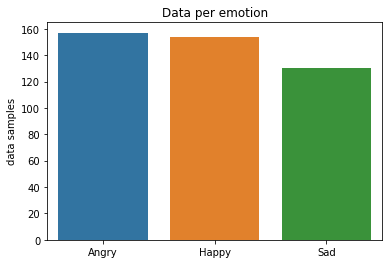

In [122]:
import seaborn as sns
sns.barplot(x=Song_df['label'].value_counts().index,y=Song_df['label'].value_counts())
plt.title("Data per emotion")
plt.ylabel('data samples')

In [123]:
ind=Song_df.loc[Song_df['label'] == "Angry"].index[:20]
ind2=Song_df.loc[Song_df['label'] == "Happy"].index[:20]
ind=ind.union(ind2)
Song_df.drop(index=ind,inplace=True)

<p>On remarque que notre data est inbalanced du coup nous allons retrancher un peu de la catégorie Angry</p>

Text(0, 0.5, 'data samples')

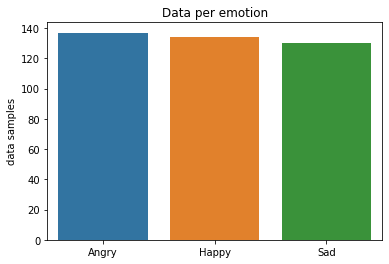

In [124]:
sns.barplot(x=Song_df['label'].value_counts().index,y=Song_df['label'].value_counts())
plt.title("Data per emotion")
plt.ylabel('data samples')

In [125]:
from sklearn.model_selection import train_test_split

X=Song_df[["sentence"]]
y=Song_df[["label"]]
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=0.2, random_state=42, shuffle=True)
X_dev, X_test, y_dev, y_test = train_test_split(X_rest, y_rest, train_size=0.5, random_state=42, shuffle=True)

In [126]:
frames = [[X_train,y_train],[X_test,y_test],[X_dev,y_dev]]
df_train = pd.concat(frames[0], axis=1)
df_test = pd.concat(frames[1], axis=1)
df_val = pd.concat(frames[2], axis=1)

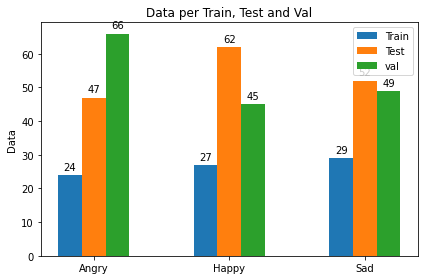

In [127]:
SIZE_Train1=list(df_train.label.value_counts().sort_index())
SIZE_Test1=list(df_test.label.value_counts().sort_index())
VAL_Test1=list(df_val.label.value_counts().sort_index())
label=Song_df.label.unique()
label.sort()
label=list(label)
barchart(label,[SIZE_Train1,SIZE_Test1,VAL_Test1])

[]

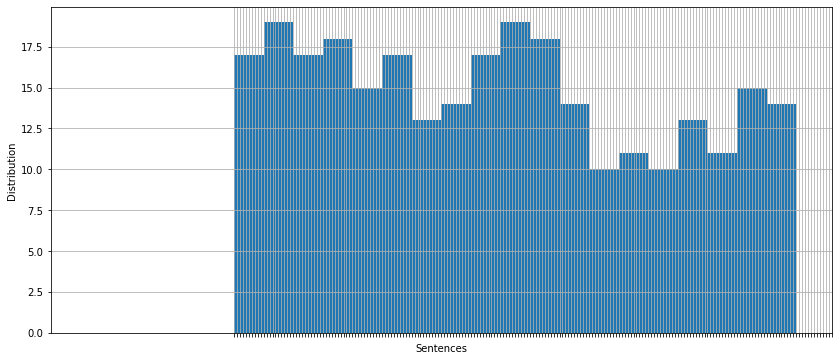

In [128]:
bin_values = np.arange(start=-50, stop=200, step=10)

fig,ax = plt.subplots(1)
Song_df['sentence'].hist(bins=bin_values, figsize=[14,6])
# # plt.axis('off')
ax.set_ylabel('Distribution')
ax.set_xlabel('Sentences')

# Turn off tick labels
ax.set_xticklabels([])

### A.3.1- Boosting data

In [129]:
def data_cleaning():
    with open('train.txt', 'r') as in_file:
        stripped = (line.strip() for line in in_file)
        lines = (line.split(";") for line in stripped if line)
        with open('train.csv', 'w') as out_file:
            writer = csv.writer(out_file)
            writer.writerow(('sentence', 'label'))
            writer.writerows(lines)

    df=pd.read_csv("train.csv")
    #delete love, surprise, fear
    ind=df.loc[df['label'] == "love"].index
    ind2=df.loc[df['label'] == "surprise"].index
    ind=ind.union(ind2)
    ind3=df.loc[df['label'] == "fear"].index
    ind=ind.union(ind3)
    df.drop(index=ind,inplace=True)

    #replace column names
    df=df.replace({'label': 'sadness'}, 'Sad')
    df=df.replace({'label': 'anger'}, 'Angry')
    df=df.replace({'label': 'joy'}, 'Happy')

    print(df['label'].unique())
    return df

In [130]:
data_cleaning().head()

['Sad' 'Angry' 'Happy']


,sentence,label
0,i didnt feel humiliated,Sad
1,i can go from feeling so hopeless to so damned...,Sad
2,im grabbing a minute to post i feel greedy wrong,Angry
4,i am feeling grouchy,Angry
5,ive been feeling a little burdened lately wasn...,Sad


['Sad' 'Angry' 'Happy']
['Sad' 'Angry' 'Happy']


Text(0, 0.5, 'data samples')

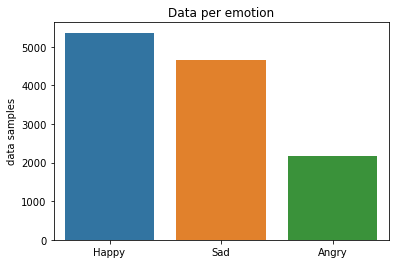

In [131]:
sns.barplot(x=data_cleaning()['label'].value_counts().index,y=data_cleaning()['label'].value_counts())
plt.title("Data per emotion")
plt.ylabel('data samples')

['Sad' 'Angry' 'Happy']


[]

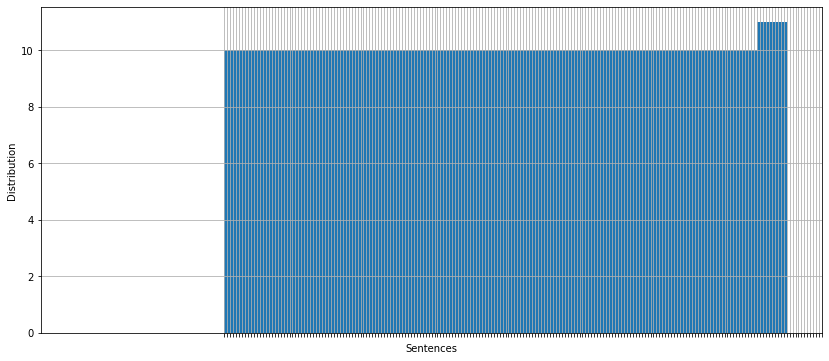

In [132]:
fig,ax = plt.subplots(1)
data_cleaning()['sentence'].hist(bins=bin_values, figsize=[14,6])
# # plt.axis('off')
ax.set_ylabel('Distribution')
ax.set_xlabel('Sentences')

# Turn off tick labels
ax.set_xticklabels([])

In [133]:
df_train=df_train.append(data_cleaning())

['Sad' 'Angry' 'Happy']


In [134]:
def barchart(labels,L):
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots()
    
    if(len(L)==3):
        ax.set_title('Data per Train, Test and Val')
        rects1 = ax.bar(x - width/2, L[0], width/2, label='Train')
        rects2 = ax.bar(x , L[1], width/2, label='Test')
        rects3 = ax.bar(x + width/2, L[2], width/2, label='val')
    else:
        ax.set_title('Data per Train and Test')
        rects1 = ax.bar(x - width/2, L[0], width, label='Train')
        rects2 = ax.bar(x + width/2, L[1], width, label='Test')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Data')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)
    if(len(L)==3):
        autolabel(rects3)
        
    fig.tight_layout()

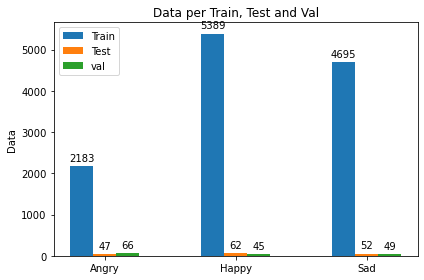

In [135]:
SIZE_Train1=list(df_train.label.value_counts().sort_index())
SIZE_Test1=list(df_test.label.value_counts().sort_index())
VAL_Test1=list(df_val.label.value_counts().sort_index())
label=Song_df.label.unique()
label.sort()
label=list(label)
barchart(label,[SIZE_Train1,SIZE_Test1,VAL_Test1])

In [136]:
df = pd.concat([df_train,df_test,df_val])
df.dtypes

sentence    object
label       object
dtype: object

In [137]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['label_enc'] = labelencoder.fit_transform(df['label'])
print(df['label_enc'])

428    1
521    2
627    2
473    1
686    1
      ..
436    1
253    1
40     0
144    0
36     0
Name: label_enc, Length: 12588, dtype: int32


In [138]:
df[['label','label_enc']].drop_duplicates(keep='first')

,label,label_enc
428,Happy,1
521,Sad,2
335,Angry,0


In [139]:
df.rename(columns={'label':'label_desc'},inplace=True)
df.rename(columns={'label_enc':'label'},inplace=True)
df.head()

,sentence,label_desc,label
428,A calm and therapeutic song with ambient sound,Happy,1
521,"Sad, Dark",Sad,2
627,Venom Soundtrack unofficial inspired version. ...,Sad,2
473,A great 8 bit vibe that sits well in the backg...,Happy,1
686,"Rock, Upbeat, Epic, Suspenseful",Happy,1


## A.4- Modeling

In [140]:
X_train=df_train['sentence'].to_numpy()
y_train=df_train['label'].to_numpy()
X_test=df_val['sentence'].to_numpy()
y_test=df_val['label'].to_numpy()

**Naive Bayes**

In [141]:
def bayes(X_train,y_train) :   
    from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.pipeline import Pipeline
    
    text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
    text_clf = text_clf.fit(X_train,y_train)
    return text_clf

**SVM**

In [142]:
def svm(X_train,y_train) :
    # Training Support Vector Machines - SVM and calculating its performance
    from sklearn.pipeline import Pipeline
    from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
    from sklearn.linear_model import SGDClassifier
    text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                             ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, random_state=42))])

    text_clf_svm = text_clf_svm.fit(X_train,y_train)
    return text_clf_svm

**mnb_stemmed**

In [143]:
def mnb_stemmed(X_train,y_train) :
    # Stemming Code

    import nltk
    nltk.download("stopwords")
    from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.pipeline import Pipeline
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer("english", ignore_stopwords=True)

    class StemmedCountVectorizer(CountVectorizer):
        def build_analyzer(self):
            analyzer = super(StemmedCountVectorizer, self).build_analyzer()
            return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
      
    stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

    text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()), 
                              ('mnb', MultinomialNB(fit_prior=False))])

    text_mnb_stemmed = text_mnb_stemmed.fit(X_train,y_train)
    return text_mnb_stemmed

**BERT**

In [57]:
!pip install transformers

In [144]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import accuracy_score,matthews_corrcoef

from tqdm import tqdm, trange,tnrange,tqdm_notebook,notebook
import random
import os
import io
%matplotlib inline

In [145]:
device = torch.device("cuda")

In [146]:
# # identify and specify the GPU as the device, later in training loop we will load data into device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

# SEED = 19

# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# if device == torch.device("cuda"):
#     torch.cuda.manual_seed_all(SEED)

In [147]:
## create label and sentence list
sentences = df.sentence.values

#check distribution of data based on labels
print("Distribution of data based on labels: ",df.label.value_counts())

# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 256

## Import BERT tokenizer, that is used to convert our text into tokens that corresponds to BERT library
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
input_ids = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences]
labels = df.label.values

print("Actual sentence before tokenization: ",sentences[2])
print("Encoded Input from dataset: ",input_ids[2])

## Create attention mask
attention_masks = []
## Create a mask of 1 for all input tokens and 0 for all padding tokens
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
print(attention_masks[2])

Distribution of data based on labels:  1    5496
2    4796
0    2296
Name: label, dtype: int64


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\MSI\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2016: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Actual sentence before tokenization:  Venom Soundtrack unofficial inspired version. This music is meant for epic villains or horror trailers. The feeling is very dark and scary. The music features dark hybrid sounds, with a hybrid orchestral mix. The track follows a movie trailer format and is about 2 minutes. The form starts out soft and mysterious, then introduces a rhythm, and finally ends with a huge climax section. Last but not least, a teaser section in the end is included, along with a few hit points for text.
Encoded Input from dataset:  [101, 15779, 6050, 11982, 4427, 2544, 1012, 2023, 2189, 2003, 3214, 2005, 8680, 16219, 2030, 5469, 21389, 1012, 1996, 3110, 2003, 2200, 2601, 1998, 12459, 1012, 1996, 2189, 2838, 2601, 8893, 4165, 1010, 2007, 1037, 8893, 13533, 4666, 1012, 1996, 2650, 4076, 1037, 3185, 9117, 4289, 1998, 2003, 2055, 1016, 2781, 1012, 1996, 2433, 4627, 2041, 3730, 1998, 8075, 1010, 2059, 13999, 1037, 6348, 1010, 1998, 2633, 4515, 2007, 1037, 4121, 14463, 2930, 10

In [148]:
train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids,labels,random_state=41,test_size=0.1)
train_masks,validation_masks,_,_ = train_test_split(attention_masks,input_ids,random_state=41,test_size=0.1)

In [164]:
# convert all our data into torch tensors, required data type for our model
# train_inputs = torch.tensor(train_inputs)
# validation_inputs = torch.tensor(validation_inputs)
# train_labels = torch.tensor(train_labels)
# validation_labels = torch.tensor(validation_labels)
# train_masks = torch.tensor(train_masks)
# validation_masks = torch.tensor(validation_masks)

train_inputs = train_inputs.clone().detach()
validation_inputs = validation_inputs.clone().detach()
train_labels = train_labels.clone().detach()
validation_labels = validation_labels.clone().detach()
train_masks = train_masks.clone().detach()
validation_masks = validation_masks.clone().detach()



# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
# train_data= torch.LongTensor(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)



validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

In [165]:
train_data[0]

(tensor([  101,  1045,  5959,  2026,  2166,  1998,  4299,  2000,  2393,  2004,
          2116,  2111,  2004,  2825,  2000,  2514, 18783,  2055,  3209,  2021,
          1045,  2064,  2069,  2265,  1996,  2126,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",force_download=True , num_labels=3).to(device)

# Parameters:
lr = 2e-5
adam_epsilon = 1e-8

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

num_warmup_steps = 0
num_training_steps = len(train_dataloader)*epochs

### In Transformers, optimizer and schedules are splitted and instantiated like this:
optimizer = AdamW(model.parameters(), lr=lr,eps=adam_epsilon,correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

In [161]:
epochs=3
for _ in notebook.trange(1,epochs+1,desc='Epoch'):
  print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")

<====================== Epoch 1 ======================>
<====================== Epoch 2 ======================>
<====================== Epoch 3 ======================>



In [ ]:
## Store our loss and accuracy for plotting
train_loss_set = []
learning_rate = []

# Gradients gets accumulated by default
model.zero_grad()

# tnrange is a tqdm wrapper around the normal python range
for _ in notebook.trange(1,epochs+1,desc='Epoch'):
  print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")
  # Calculate total loss for this epoch
  batch_loss = 0

  for step, batch in enumerate(train_dataloader):
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    
    # Add batch to GPU
#     batch = tuple(t.to(device) for t in batch)
    batch = tuple(t for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Forward pass
    b_labels = b_labels.type(torch.LongTensor)
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    
    # Backward pass
    loss.backward()
    
    # Clip the norm of the gradients to 1.0
    # Gradient clipping is not in AdamW anymore
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update learning rate schedule
    scheduler.step()

    # Clear the previous accumulated gradients
    optimizer.zero_grad()
    
    # Update tracking variables
    batch_loss += loss.item()

  # Calculate the average loss over the training data.
  avg_train_loss = batch_loss / len(train_dataloader)

  #store the current learning rate
  for param_group in optimizer.param_groups:
    print("\n\tCurrent Learning rate: ",param_group['lr'])
    learning_rate.append(param_group['lr'])
    
  train_loss_set.append(avg_train_loss)
  print(F'\n\tAverage Training loss: {avg_train_loss}')
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_accuracy,eval_mcc_accuracy,nb_eval_steps = 0, 0, 0

  # Evaluate data for one epoch
  df_ = pd.DataFrame(columns=["Epoch","Actual_class","Predicted_class"])
  for batch in validation_dataloader:
    # Add batch to GPU
#     batch = tuple(t.to(device) for t in batch)
    batch = tuple(t for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    
    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    inputs_flat=b_input_ids.flatten()
    
    df_metrics=pd.DataFrame({'Epoch':epochs,'Actual_class':labels_flat,'Predicted_class':pred_flat})
    # df_=pd.concat([df_,df_metrics], axis=0)
    df_=df_.append(df_metrics)


    tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
    tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)
    
    eval_accuracy += tmp_eval_accuracy
    eval_mcc_accuracy += tmp_eval_mcc_accuracy
    nb_eval_steps += 1

  print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
  print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')

## A.5- Evaluation

In [347]:
predicted=bayes(X_train,y_train).predict(X_test)
predicted_svm= svm(X_train,y_train).predict(X_test)
predicted_mnb_stemmed = mnb_stemmed(X_train,y_train).predict(X_test)

C:\Users\MSI\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [348]:
from sklearn.metrics import classification_report
print("-----------Naive Bayes ----------------")
print(classification_report(y_test,predicted))
print("-----------SVM ----------------")
print(classification_report(y_test,predicted_svm))
print("-----------mnb_stemmed ----------------")
print(classification_report(y_test,predicted_mnb_stemmed))

-----------Naive Bayes ----------------
              precision    recall  f1-score   support

       Angry       0.65      0.50      0.56        66
       Happy       0.57      0.78      0.66        45
         Sad       0.44      0.43      0.43        49

    accuracy                           0.56       160
   macro avg       0.55      0.57      0.55       160
weighted avg       0.56      0.56      0.55       160

-----------SVM ----------------
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        66
       Happy       0.32      0.91      0.47        45
         Sad       0.47      0.31      0.37        49

    accuracy                           0.35       160
   macro avg       0.26      0.41      0.28       160
weighted avg       0.23      0.35      0.25       160

-----------mnb_stemmed ----------------
              precision    recall  f1-score   support

       Angry       0.58      0.65      0.61        66
       Happy     

C:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df[['label','label_desc']].drop_duplicates(keep='first')

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = labels_flat
y_pred = pred_flat
confusion_matrix(y_true, y_pred)

In [ ]:
df_[['Actual_class','Predicted_class']].to_numpy()

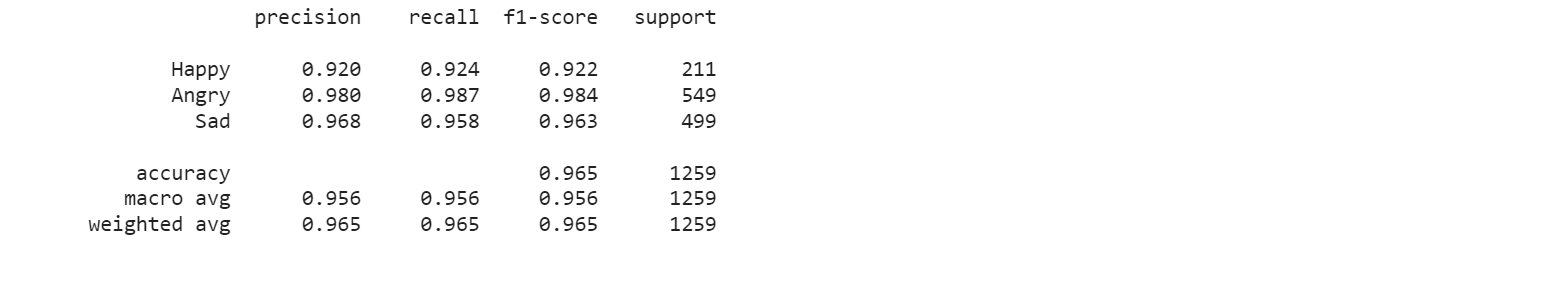

In [193]:
# print(classification_report(df_.Actual_class.astype(int).values, df_.Predicted_class.astype(int).values, target_names=label2int.keys(), digits=len(label2int)))
display(Image(filename="metric_plot.PNG"))

# B) Emotion recognition


## B.2- Data understanding

Les données sont récupérées depuis Kaggle. Ils consistent en des images des visages sous formes des pixels 48x48 en niveaux de gris. Les visages ont été automatiquement enregistrés de sorte que le visage soit plus ou moins centré et occupe à peu près la même quantité d'espace dans chaque image. La tâche consiste à classer chaque visage en fonction de l'émotion représentée par l'expression du visage dans l'une des sept catégories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

   ## B.3- Data preparation

In [68]:
%config IPCompleter.greedy=True

In [69]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

In [70]:
df = pd.read_csv('./fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [71]:
df.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

In [72]:
df.shape

(35887, 3)

In [73]:
df.isna().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [74]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [75]:
df=df[df.emotion.isin({0,3,4,6})]

In [76]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
0    4953
Name: emotion, dtype: int64

In [77]:
df.shape

(26217, 3)

In [78]:
df.Usage.value_counts()

Training       21005
PublicTest      2622
PrivateTest     2590
Name: Usage, dtype: int64

In [79]:
df.emotion.unique()

array([0, 4, 6, 3], dtype=int64)

In [80]:
x_train=['angry', 'happy', 'sad','Neutral']
y_train=[df.where(df.emotion==i).dropna().Usage.value_counts()['Training'] for i in[0,3,4,6]]
y_test=[df.where(df.emotion==i).dropna().Usage.value_counts()[['PublicTest','PrivateTest']].sum() for i in[0,3,4,6]]

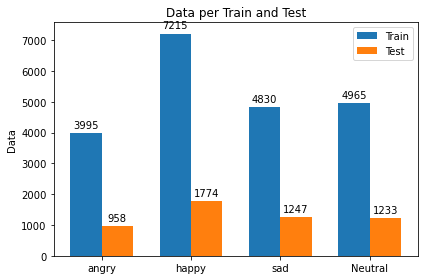

In [81]:
barchart(x_train,[y_train,y_test])

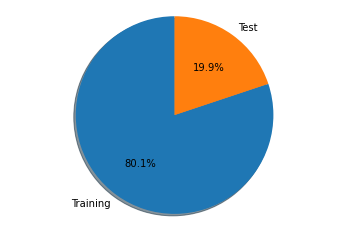

In [82]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Training', 'Test']
sizes = [sum(y_train), sum(y_test)]
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

   ### Data conversion to images


In [91]:
# convert string to integer
def atoi(s):
    n = 0
    for i in s:
        n = n*10 + ord(i) - ord("0")
    return n

# making folders
outer_names = ['test','train']
inner_names = ['angry', 'happy', 'sad', 'neutral']
os.makedirs('data', exist_ok=True)
for outer_name in outer_names:
    os.makedirs(os.path.join('data',outer_name), exist_ok=True)
    for inner_name in inner_names:
        os.makedirs(os.path.join('data',outer_name,inner_name), exist_ok=True)

In [92]:
# to keep count of each category
angry = 0
happy = 0
sad = 0
neutral = 0
angry_test = 0
happy_test = 0
sad_test = 0
neutral_test = 0

In [93]:
mat = np.zeros((48,48),dtype=np.uint8)

In [94]:
df.reset_index(drop=True, inplace=True)

In [95]:
# read the csv file line by line
for i in tqdm(range(len(df))):
    txt = df['pixels'][i]
    words = txt.split()
    
    # the image size is 48x48
    for j in range(2304):
        xind = j // 48
        yind = j % 48
        mat[xind][yind] = atoi(words[j])

    img = Image.fromarray(mat)

    # train
    if i < 19211:
        if df['emotion'][i] == 0:
            img.save('./data/train/angry/im'+str(angry)+'.png')
            angry += 1
        elif df['emotion'][i] == 3:
            img.save('./data/train/happy/im'+str(happy)+'.png')
            happy += 1
        elif df['emotion'][i] == 4:
            img.save('./data/train/sad/im'+str(sad)+'.png')
            sad += 1
        elif df['emotion'][i] == 6:
            img.save('./data/train/neutral/im'+str(neutral)+'.png')
            neutral += 1

    # test
    else:
        if df['emotion'][i] == 0:
            img.save('./data/test/angry/im'+str(angry_test)+'.png')
            angry_test += 1
        elif df['emotion'][i] == 3:
            img.save('./data/test/happy/im'+str(happy_test)+'.png')
            happy_test += 1
        elif df['emotion'][i] == 4:
            img.save('./data/test/sad/im'+str(sad_test)+'.png')
            sad_test += 1
        elif df['emotion'][i] == 6:
            img.save('./data/test/neutral/im'+str(neutral_test)+'.png')
            neutral_test += 1

print("Done!")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26217/26217 [01:32<00:00, 282.84it/s]

Done!


'angry'

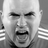

'happy'

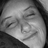

'neutral'

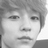

'sad'

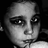

In [96]:
from IPython.display import Image,display
from glob import glob
import os
for path in glob("./data/train/*/im3.png"):
    #print(glob(path+"*.png/"))
    
    display(os.path.basename(os.path.dirname(path.replace("\\","/"))),Image(filename=path, width = 100, height = 100))

## B.4- Modeling

In [188]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from IPython.display import Image
# display(Image(filename="eva.png"))
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
# Define data generators
train_dir = 'data/train'
val_dir = 'data/test'

num_train = 21005
num_val = 5212
batch_size = 64
num_epoch = 50

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

In [171]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [174]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         1

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
model_info = model.fit_generator(
        train_generator,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=validation_generator,
        validation_steps=num_val // batch_size)
model.save_weights('model_3.h5')

## B.5- Evaluation

In [172]:
# plots accuracy and loss curves
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

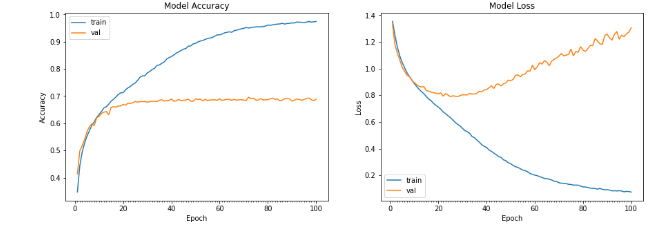

In [189]:
plot_model_history(model_info)

In [173]:
from PIL import Image
import numpy as np
import cv2
from IPython.display import clear_output
import time
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np
model.load_weights('model_3.h5')
emotion_dict = {0: "Angry", 1: "Happy", 2: "Neutral", 3: "Sad"}

In [175]:
def get_frame(cam):
   # Capture frame-by-frame
    ret, frame = cam.read()
    #flip image for natural viewing
    frame = cv2.flip(frame, 1)
    return frame


#Use 'jpeg' instead of 'png' (~5 times faster)
def array_to_image(a, fmt='jpeg'):
   #Create binary stream object
    f = BytesIO()

   #Convert array to binary stream object
    PIL.Image.fromarray(a).save(f, fmt)

    return IPython.display.Image(data=f.getvalue())

In [176]:
cam = cv2.VideoCapture(0)

d = IPython.display.display("", display_id=1)
d2 = IPython.display.display("", display_id=2)
T_start=time.time()
List_predictions=[]
while True:
    try:
        t1 = time.time()
        frame = get_frame(cam)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
            roi_gray = gray[y:y + h, x:x + w]
            cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
            prediction = model.predict(cropped_img)
#             print(prediction[0])
            List_predictions.append(prediction[0])
            maxindex = int(np.argmax(prediction))
            
            cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        im = Image.fromarray(frame, 'RGB')

        d.update(im)

        t2 = time.time()

        s = f"""{int(1/(t2-t1))} FPS"""
        d2.update( IPython.display.HTML(s) )
        
        if (t2-T_start)>15:            
            cam.release()
            IPython.display.clear_output()
            print ("Stream stopped")
            pred=np.array(List_predictions)
            moy_pred=np.mean(pred, axis=0)
            max_pred=int(np.argmax(moy_pred))
#             print(emotion_dict[max_pred])
            print("You are ",emotion_dict[max_pred])
            break
    except KeyboardInterrupt:
        print()
        cam.release()
        IPython.display.clear_output()
        print ("Stream stopped")
        break

Stream stopped
You are  Happy


In [177]:
cam.release()
IPython.display.clear_output()

In [186]:
from IPython.display import HTML

music_df=pd.read_csv("Songs.csv")
link= music_df.loc[music_df["Category"]==emotion_dict[max_pred]].sample()['Youtube link']
HTML('<iframe width="560" height="315" src="{}" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'.format(link.to_string().split()[1]))

# Thank you